In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [56]:
csv_path = "./merged_wpv_cleaned.csv"

try:
    df = pd.read_csv(csv_path)
    print("Successfully loaded:", csv_path)
except Exception as e:
    print("Could not load CSV:", e)
    raise

print("\n[1] Initial Data Shape:", df.shape)

# Remove duplicated columns if any
df = df.loc[:, ~df.columns.duplicated()].copy()

# Remove duplicate rows
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print("[2] Duplicates removed:", initial_rows - df.shape[0], "rows")

# Convert event_time to datetime if applicable
if "event_time" in df.columns:
    df["event_time"] = pd.to_datetime(df["event_time"], errors="coerce")
    # Drop rows with invalid or missing event_time
    invalid_times = df["event_time"].isnull().sum()
    if invalid_times > 0:
        df.dropna(subset=["event_time"], inplace=True)
        print("[3] Dropped rows with invalid event_time:", invalid_times)

df.reset_index(drop=True, inplace=True)

print("\n[4] After basic cleaning, shape:", df.shape)
print("\nColumns:", df.columns.tolist())

Successfully loaded: ./merged_wpv_cleaned.csv

[1] Initial Data Shape: (570, 18)
[2] Duplicates removed: 1 rows

[4] After basic cleaning, shape: (569, 18)

Columns: ['event_time', 'victim_profession', 'department', 'perpetrator_type', 'violence_type', 'emotional_impact', 'assault_desc', 'response_action', 'contributing_factors', 'physical_injury_level', 'osha_recordable', 'charges_pressed', 'law_enforcement_contacted', 'nature_of_injury', 'injury_location', 'source_file', 'source_sheet', 'severity']


In [57]:
# 2 EDA
print("\n=== DESCRIPTIVE STATISTICS (INCLUDE ALL) ===")
print(df.describe(include="all"))

print("\n=== MISSING VALUE COUNTS ===")
missing_counts = df.isnull().sum().sort_values(ascending=False)
print(missing_counts)

# 2.2 BOXPLOTS FOR NUMERIC COLUMNS
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if numeric_cols:
    print("\n=== BOX PLOTS FOR NUMERIC COLUMNS ===")
    for col in numeric_cols:
        plt.figure()
        plt.boxplot(df[col].dropna(), vert=True)
        plt.title("Box Plot of " + col)
        plt.xlabel(col)
        plt.ylabel("Value")
        plt.show()
else:
    print("\nNo numeric columns found for box plots.")


=== DESCRIPTIVE STATISTICS (INCLUDE ALL) ===
                           event_time         victim_profession  \
count                             569                       569   
unique                            NaN                        73   
top                               NaN  PSYCHIATRIC TECHNICIAN I   
freq                              NaN                        83   
mean    2024-10-26 19:36:52.124780288                       NaN   
min               2024-08-01 00:00:00                       NaN   
25%               2024-10-07 11:37:00                       NaN   
50%               2024-10-11 16:26:08                       NaN   
75%               2024-12-01 00:00:00                       NaN   
max               2025-01-31 00:00:00                       NaN   

                  department perpetrator_type             violence_type  \
count                    569              547                       569   
unique                    68                4                     

In [58]:
# 2.3 CROSS-TAB AND STACKED BAR FOR MULTI-DIMENSIONAL CATEGORICAL
cat_cols = ["severity", "victim_profession", "department"]

for c in cat_cols:
    if c not in df.columns:
        print(f"Warning: {c} not in columns. Skipping cross-tab for {c}.")

if all(c in df.columns for c in cat_cols):
    pivot_data = df.pivot_table(
        index="victim_profession",
        columns="severity",
        values="department",
        aggfunc="count"
    ).fillna(0)

    print("\n=== Cross Tab: Victim Profession vs Severity (Counting Department) ===")
    print(pivot_data)


=== Cross Tab: Victim Profession vs Severity (Counting Department) ===
severity                         Mild - Mild Soreness/Abrasions/Scratches/Small Bruises  \
victim_profession                                                                         
                                                                              10.0        
ASST MGR- NURSING                                                              1.0        
Administration/Support Services                                                0.0        
CERTIFIED NURSING ASSIST II                                                    1.0        
CERTIFIED NURSING ASSISTANT I                                                  3.0        
...                                                                            ...        
Staff                                                                          0.0        
Staff Nurse                                                                   42.0        
Staff/CPD         

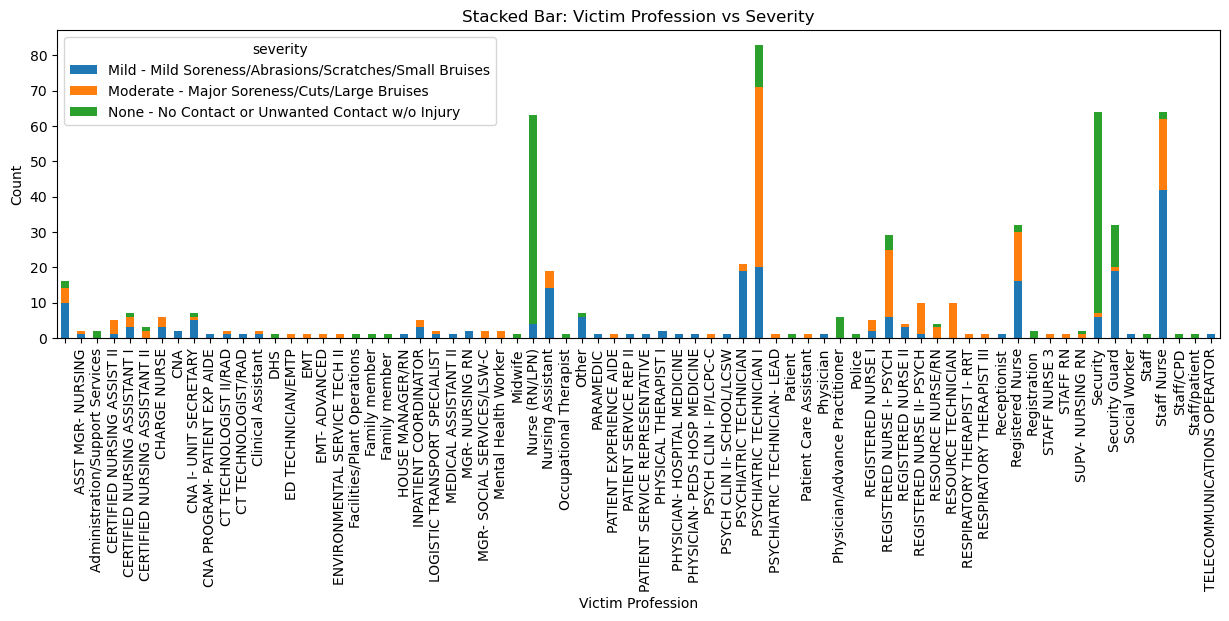

In [59]:
# Stacked bar chart
pivot_data.plot(kind="bar", stacked=True, figsize=(15,4))
plt.title("Stacked Bar: Victim Profession vs Severity")
plt.xlabel("Victim Profession")
plt.ylabel("Count")
plt.show()

In [60]:
group_data = df.groupby(["department", "victim_profession", "severity"]).size().unstack(fill_value=0)
print("\n=== 3D Group Info: (Department, Victim Profession) vs Severity ===")
print(group_data.head(10))


=== 3D Group Info: (Department, Victim Profession) vs Severity ===
severity                                                     Mild - Mild Soreness/Abrasions/Scratches/Small Bruises  \
department                  victim_profession                                                                         
ACU                         Family member                                                                    0        
                            Nurse (RN/LPN)                                                                   3        
                            Physician/Advance Practitioner                                                   0        
                            Security                                                                         0        
Admin                       Administration/Support Services                                                  0        
Behav Hlth Clinic - Schools PSYCH CLIN II- SCHOOL/LCSW                                             

Index(['Emergency Department', 'Katahdin 2 South', 'ER', 'ACU',
       'Katahdin 2 North'],
      dtype='object', name='department')
group_data index departments: Index(['ACU', 'ER', 'Emergency Department', 'Katahdin 2 North',
       'Katahdin 2 South'],
      dtype='object', name='department')


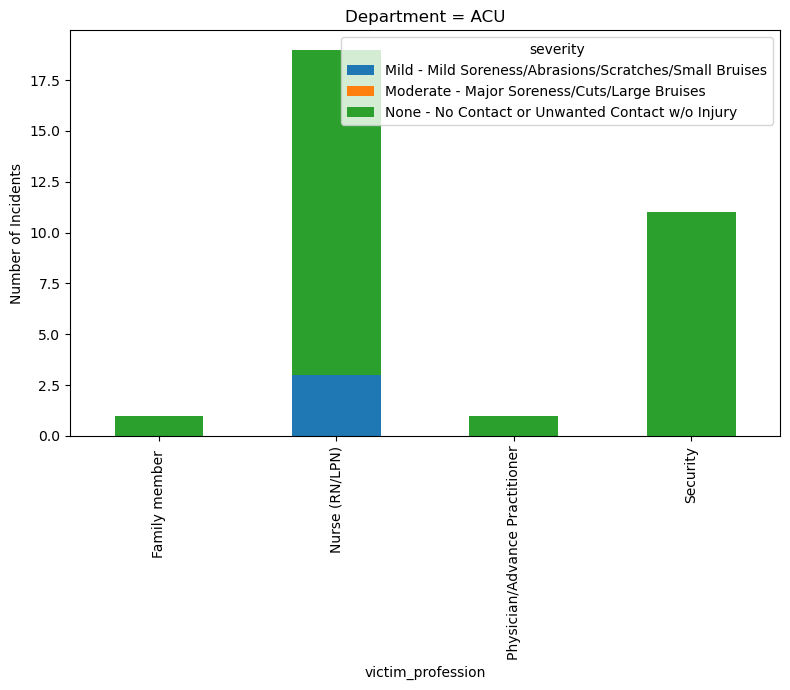

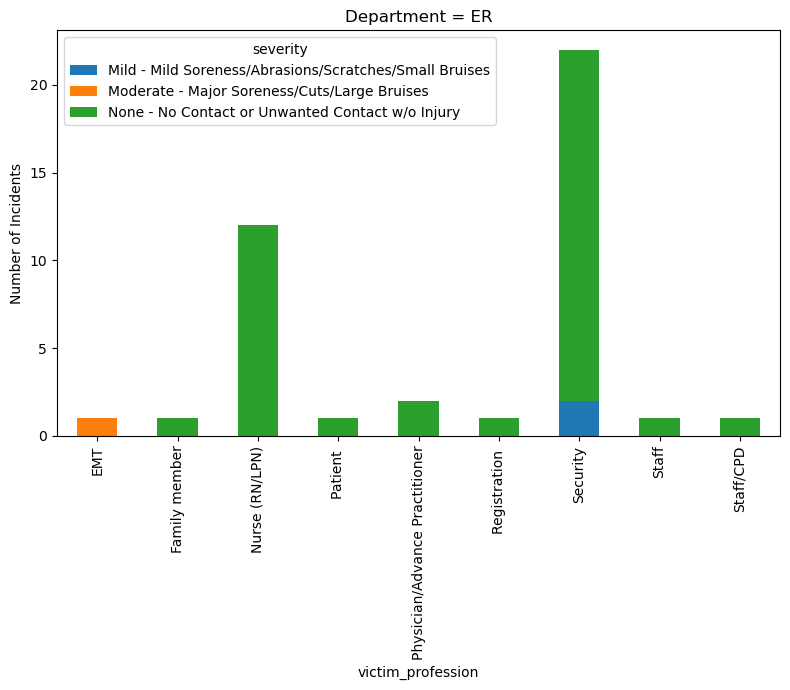

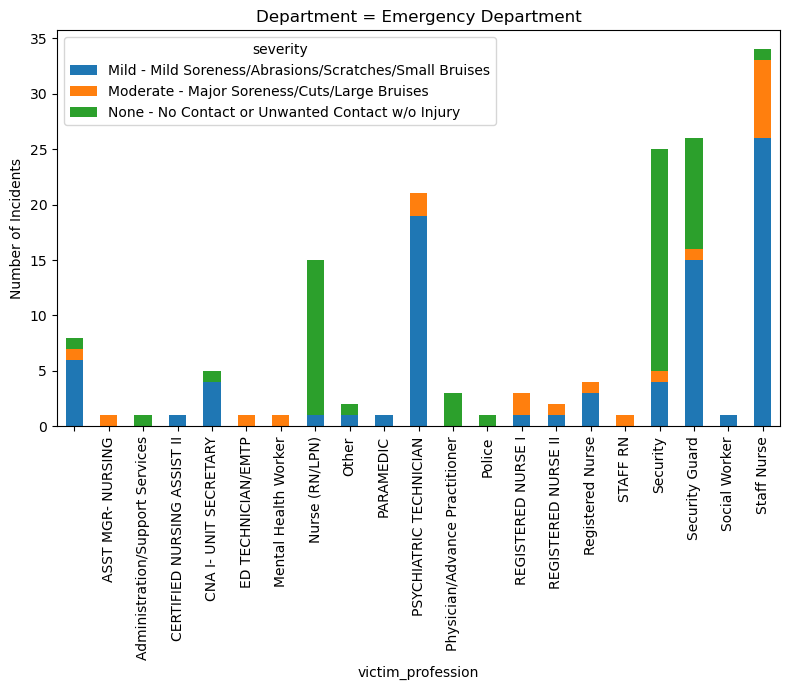

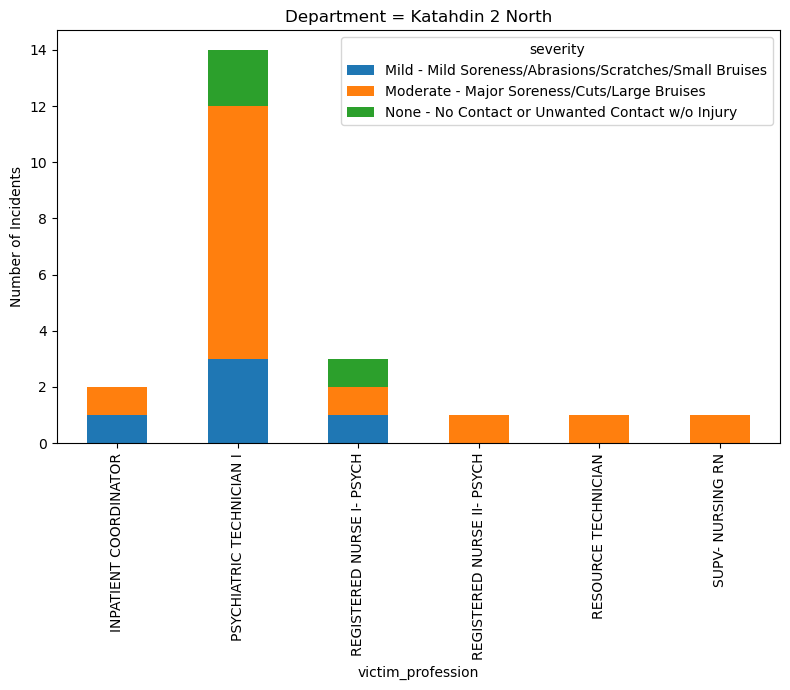

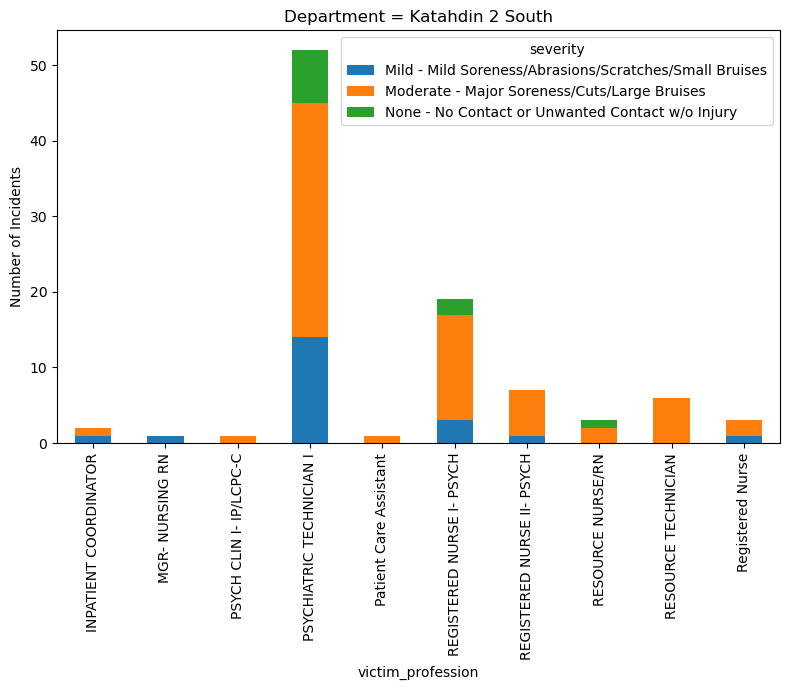

In [61]:
top5_depts = (
    df["department"]
    .value_counts(dropna=True)
    .head(5)
    .index
)
print(top5_depts)
df_sub = df[df["department"].isin(top5_depts)].copy()

group_data = (
    df_sub.groupby(["department", "victim_profession", "severity"])
    .size()
    .unstack(fill_value=0)
)
print("group_data index departments:", group_data.index.get_level_values("department").unique())


for dept, sub_df in group_data.groupby(level="department"):
    sub_df = sub_df.droplevel(level="department")

    sub_df.plot(
        kind="bar", 
        stacked=True, 
        figsize=(8,7),
        title=f"Department = {dept}"
    )
    plt.ylabel("Number of Incidents")
    plt.tight_layout()
    plt.show()

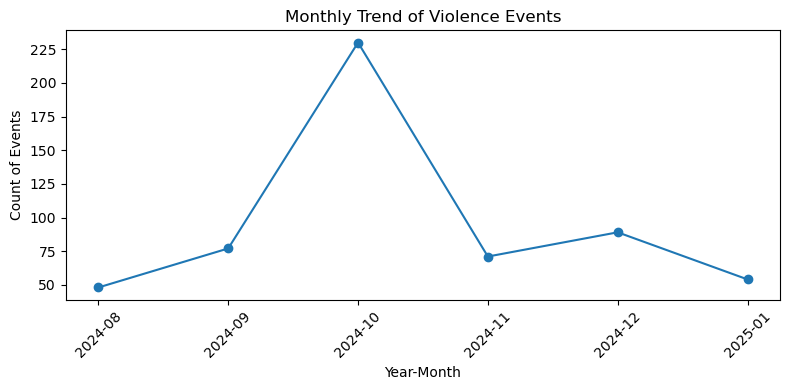

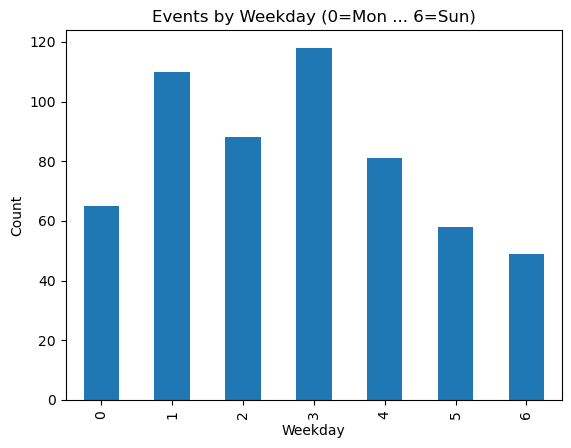

In [62]:
# 2.4 TIME DISTRIBUTION AND TRENDS
if "event_time" in df.columns:
    df["year_month"] = df["event_time"].dt.to_period("M").astype(str)
    monthly_counts = df.groupby("year_month")["event_time"].count().sort_index()

    plt.figure(figsize=(8,4))
    monthly_counts.plot(marker='o')
    plt.title("Monthly Trend of Violence Events")
    plt.xlabel("Year-Month")
    plt.ylabel("Count of Events")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    df["weekday"] = df["event_time"].dt.weekday 
    weekday_counts = df["weekday"].value_counts().sort_index()
    plt.figure()
    weekday_counts.plot(kind="bar")
    plt.title("Events by Weekday (0=Mon ... 6=Sun)")
    plt.xlabel("Weekday")
    plt.ylabel("Count")
    plt.show()